In [7]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchcrf import CRF
import convert_data_to_lstm as cdtl
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

torch.manual_seed(1)

In [8]:
class biLSTM(nn.Module):
    def __init__(self, class_to_ix, features_dim, hidden_dim, crf):
        super(biLSTM, self).__init__()
        self.features_dim = features_dim
        self.hidden_dim = hidden_dim
        self.class_to_ix = class_to_ix
        self.target_size = len(class_to_ix)
        self.dropout = nn.Dropout(p=0.2)
        self.crf = crf
        # biLSTM init
        self.lstm = nn.LSTM(features_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)
        # maps the output of the lstm into the classes space
        self.hidden_to_class = nn.Linear(hidden_dim, self.target_size)

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _get_lstm_features(self, sequence):
        self.hidden = self.init_hidden()
        sequence = sequence.view(len(sequence), 1, -1)
        lstm_out, self.hidden = self.lstm(sequence, self.hidden)
        lstm_out = lstm_out.view(len(sequence), self.hidden_dim)
        
        lstm_features = self.hidden_to_class(lstm_out)
        # lstm_features = F.log_softmax(lstm_features, dim=1)
        return lstm_features

    def neg_log_likelihood(self, sequence, classes):
        features = self._get_lstm_features(sequence).view(7, 1, 5)
        loss = self.crf.forward(features, classes)
        return -1 * loss

    def forward(self, sequence):
        # Get the emission scores from the BiLSTM
        lstm_features = self._get_lstm_features(sequence)
        # Find the best path, given the features.
        lstm_features = lstm_features.view(7, 1, 5)
        class_seq = self.crf.decode(lstm_features)
        lstm_features = F.log_softmax(lstm_features.view(7, 5), dim=1)
        return class_seq, lstm_features

In [9]:
def calc_accuracy(gold, predictions):
    count = 0
    for idx in range(len(gold)):
        if gold[idx] == predictions[0][idx]:
            count += 1
    return count

In [10]:
def predict_sequences(training_data, test_data, model):
    y_pred = []
    y_true = []
    with torch.no_grad():
        prechecks = [data[0] for data in training_data]
        labels = [data[1] for data in training_data]
        prechecks = torch.tensor(prechecks, dtype=torch.float)
        total_correct = 0
        total_predictions = len(prechecks)
        for idx, precheck in enumerate(prechecks):
            labels[idx] = [int(num) for num in labels[idx]]
            outputs, _ = model(precheck)
            for output in outputs[0]:
                y_pred.append(output)
            for label in labels[idx]:
                y_true.append(label)
            total_correct += calc_accuracy(labels[idx], outputs)
        #train_acc = total_correct/(total_predictions * 7)
        train_acc = accuracy_score(y_true, y_pred)
        f1score_train = f1_score(y_true, y_pred, average='weighted')
        precision_train = precision_score(y_true, y_pred, average='weighted')
        recall_train = recall_score(y_true, y_pred, average='weighted')
        print(
            f'model accuracy after training: {train_acc}')
        print(f'model f1 score for training: {f1score_train}')
        print(f'model precision score for training: {precision_train}')
        print(f'model recall score for training: {recall_train}')
    y_pred = []
    y_true = []
    with torch.no_grad():
        prechecks = [data[0] for data in test_data]
        labels = [data[1] for data in test_data]
        total_correct = 0
        total_predictions = len(prechecks)
        prechecks = torch.tensor(prechecks, dtype=torch.float)
        for idx, precheck in enumerate(prechecks):
            labels[idx] = [int(num) for num in labels[idx]]
            outputs, _ = model(precheck)
            for output in outputs[0]:
                y_pred.append(output)
            for label in labels[idx]:
                y_true.append(label)
            total_correct += calc_accuracy(labels[idx], outputs)
        #test_acc = total_correct/(total_predictions * 7)
        test_acc = accuracy_score(y_true, y_pred)
        f1score_test = f1_score(y_true, y_pred, average='weighted')
        precision_test = precision_score(y_true, y_pred, average='weighted')
        recall_test = recall_score(y_true, y_pred, average='weighted')
        print(
            f'model accuracy after test: {test_acc}')
        print(f'model f1 score for training: {f1score_test}')
        print(f'model precision score for test: {precision_test}')
        print(f'model recall score for test: {recall_test}')
    return train_acc, test_acc, f1score_train, f1score_test, precision_train, precision_test, recall_train, recall_test

In [11]:
def main():
    #####################################################################
    # data loader and manipulation:
    #####################################################################
    covid = cdtl.load_data()
    HIDDEN_DIM = 16
    FEATURES_DIM = len(covid.drop(
        [' Country', 'Date', 'target'], axis=1).columns)
    countries = cdtl.get_country_names(covid)
    training_data = cdtl.data_to_lstm_input(
        covid, countries, '2020-03-05', '2020-07-16')
    test_data = cdtl.data_to_lstm_input(
        covid, countries, '2020-07-16', '2020-08-11')
    classes_to_ix = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
    #classes_to_ix = {0: 0, 1: 1, 2: 2, 3: 3}
    num_tags = 5 #change back to 4 after tests
    #####################################################################
    # initialize model and optimizer:
    #####################################################################
    crf = CRF(num_tags)
    model = biLSTM(classes_to_ix, FEATURES_DIM, HIDDEN_DIM, crf)
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    accumulated_grad_steps = 1
    #####################################################################
    # training:
    #####################################################################
    model.train()
    total_train_acc_values = []
    total_test_acc_values = []
    total_f1_train_values = []
    total_f1_test_values = []
    total_precision_train_values = []
    total_precision_test_values = []
    total_recall_train_values = []
    total_recall_test_values = []
    epoch_loss = []
    best_test_acc = 0.61
    for epoch in range(
            300):
        count = 0
        total_epoch_loss = 0
        i = 0
        loss_values = []
        train_acc_values = []
        test_acc_values = []
        f1_train_values = []
        f1_test_values = []
        precision_train_values = []
        precision_test_values = []
        recall_train_values = []
        recall_test_values = []
        print('Number of epoch: {}'.format(epoch))
        for country in countries:
            print(f'Training on {country}')
            for sequence, classes in training_data[country]:
                i += 1
                #model.zero_grad()
                sequence = torch.tensor(sequence, dtype=torch.float)
                classes = torch.tensor(classes, dtype=torch.long)
                _, lstm_features = model(sequence)
                loss = criterion(lstm_features, classes)
                loss = loss / accumulated_grad_steps
                loss.backward()

                if i % accumulated_grad_steps == 0:
                    optimizer.step()
                    model.zero_grad()

                total_epoch_loss += loss.item()
                count += 1
            print(f'Average loss for epoch {epoch}: {total_epoch_loss/count}')
            loss_values.append(total_epoch_loss/count)

            train_acc, test_acc, f1_train, f1_test, precision_train, precision_test, recall_train, recall_test = predict_sequences(training_data[country], test_data[country], model)
            train_acc_values.append(train_acc)
            test_acc_values.append(test_acc) 
            f1_train_values.append(f1_train)
            f1_test_values.append(f1_test)
            precision_train_values.append(precision_train)
            precision_test_values.append(precision_test)
            recall_train_values.append(recall_train)
            recall_test_values.append(recall_test)
        total_loss = sum(loss_values) / len(countries)
        total_train_acc = sum(train_acc_values) / len(countries)
        total_test_acc = sum(test_acc_values) / len(countries)
        total_f1_train = sum(f1_train_values) / len(countries)
        total_f1_test = sum(f1_test_values) / len(countries)
        total_precision_train = sum(precision_train_values) / len(countries)
        total_precision_test = sum(precision_test_values) / len(countries)
        total_recall_train = sum(recall_train_values) / len(countries)
        total_recall_test = sum(recall_test_values) / len(countries)
        print(f'total train acc for epoch {epoch}: {total_train_acc}, total test acc for epoch {epoch}: {total_test_acc}')
        print(f'total train f1 score for epoch {epoch}: {total_f1_train}, total test f1 score for epoch {epoch}: {total_f1_test} ')
        print(f'total train precision score for epoch {epoch}: {total_precision_train}, total test precision score for epoch {epoch}: {total_precision_test} ')
        print(f'total train recall score for epoch {epoch}: {total_recall_train}, total test recall score for epoch {epoch}: {total_recall_test} ')
        epoch_loss.append(total_loss)
        total_train_acc_values.append(total_train_acc)
        total_test_acc_values.append(total_test_acc)
        total_f1_train_values.append(total_f1_train)
        total_f1_test_values.append(total_f1_test)
        total_precision_train_values.append(total_precision_train)
        total_precision_test_values.append(total_precision_test)
        total_recall_train_values.append(total_recall_train)
        total_recall_test_values.append(total_recall_test)
        if total_test_acc > best_test_acc and total_train_acc > total_test_acc:
            best_test_acc = total_test_acc
            torch.save(model.state_dict(), f'final_one_layer_lstm_pickle_one_month_world_model_{best_test_acc}_test_acc_{total_f1_test}_f1_{total_precision_test}_pre_{total_recall_test}_re_{epoch}_epoch_allfeatures.pkl')
            torch.save(model.state_dict(), f'final_one_layer_lstm_one_month_world_model_{best_test_acc}_test_acc_{total_f1_test}_f1_{total_precision_test}_pre_{total_recall_test}_re_{epoch}_epoch_allfeatures.pth')
            torch.save(model, f'final_one_layer_lstm_entire_model_one_month_world_model_{best_test_acc}_test_acc_{total_f1_test}_f1_{total_precision_test}_pre_{total_recall_test}_re_{epoch}_epoch_allfeatures.pth')
        if epoch == 42:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.011
    plt.plot(total_train_acc_values)
    plt.plot(total_test_acc_values)
    plt.show()
    plt.plot(epoch_loss)
    plt.show()
    plt.plot(total_f1_train_values)
    plt.plot(total_f1_test_values)
    plt.show()
    plt.plot(total_precision_train_values)
    plt.plot(total_precision_test_values)
    plt.show()
    plt.plot(total_recall_train_values)
    plt.plot(total_recall_test_values)
    plt.show()

Working on United States of America
Working on Italy
Working on India
Working on Germany
Working on Mexico
Working on United Arab Emirates
Working on Brazil
Working on Republic of Korea
Working on Israel
Working on Saudi Arabia
Working on Japan
Working on United States of America
Working on Italy
Working on India
Working on Germany
Working on Mexico
Working on United Arab Emirates
Working on Brazil
Working on Republic of Korea
Working on Israel
Working on Saudi Arabia
Working on Japan
Number of epoch: 0
Training on United States of America


<ipython-input-11-670682839f33>:60: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  classes = torch.tensor(classes, dtype=torch.long)


Average loss for epoch 0: 1.2899859622120857
model accuracy after training: 0.7109375
model f1 score for training: 0.5908247716894977
model precision score for training: 0.50543212890625
model recall score for training: 0.7109375


/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model accuracy after test: 0.0
model f1 score for training: 0.0
model precision score for test: 0.0
model recall score for test: 0.0
Training on Italy
Average loss for epoch 0: 1.259102806681767
model accuracy after training: 0.578125
model f1 score for training: 0.4235767326732673
model precision score for training: 0.334228515625
model recall score for training: 0.578125
model accuracy after test: 0.0
model f1 score for training: 0.0
model precision score for test: 0.0
model recall score for test: 0.0
Training on India
Average loss for epoch 0: 1.2149892387290795
model accuracy after training: 0.78125
model f1 score for training: 0.6925940438871473
model precision score for training: 0.6220087274774775
model recall score for training: 0.78125
model accuracy after test: 0.02040816326530612
model f1 score for training: 0.039999999999999994
model precision score for test: 1.0
model recall score for test: 0.02040816326530612
Training on Germany
Average loss for epoch 0: 1.135670240852050

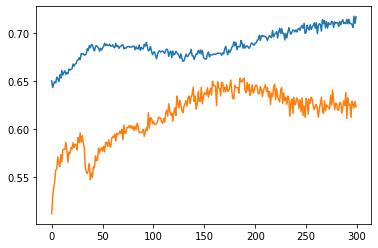

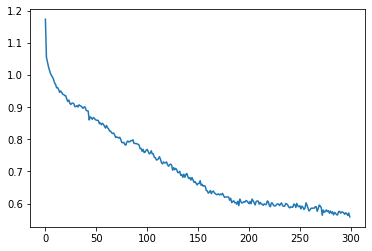

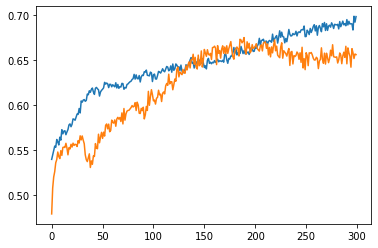

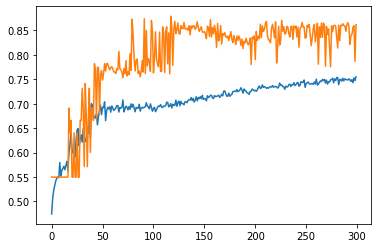

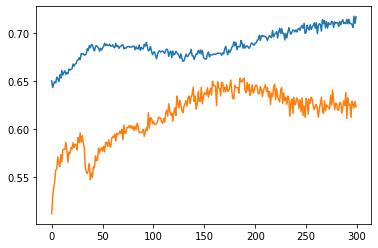

In [12]:
if __name__ == "__main__":
    main()